# ECE143 Group 10 Final Project

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import regex as re
import datetime
from scipy import stats

## 1. Import Data

In [110]:
import zipfile
def read_zip(fname):
    with zipfile.ZipFile(fname, 'r') as z:
        with z.open(z.namelist()[0]) as f:
            return pd.read_csv(f)

In [111]:
df_begin = read_zip('archive/cleaned_BegInv.csv.zip')
df_end = read_zip('archive/cleaned_EndInv.csv.zip')
df_sale = read_zip('archive/cleaned_Sales.csv.zip')
df_pur2017 = read_zip('archive/2017PurchasePricesDec.csv.zip')
df_pur2016 = read_zip('archive/PurchasesFINAL12312016.csv.zip')
df_invoice = read_zip('archive/InvoicePurchases12312016.csv.zip')

In [112]:
df_invoice['InvoiceDate'] = pd.to_datetime(df_invoice['InvoiceDate'])
df_invoice['PayDate'] = pd.to_datetime(df_invoice['PayDate'])
df_pur2016['InvoiceDate'] = pd.to_datetime(df_pur2016['InvoiceDate'])
df_pur2016['ReceivingDate'] = pd.to_datetime(df_pur2016['ReceivingDate'])
df_pur2016['PODate'] = pd.to_datetime(df_pur2016['PODate'])

In [113]:
custom_palette = {
    1: 'salmon',
    2: 'c',
}

## 2. Overview of Seperate Datasets 

### A. sales
- There are three tables record the sales information
1. cleaned_BegInv.csv: the stock at the beginning
2. cleaned_EndInv.csv: the stock in the end
3. cleaned_Sales.csv: the detail(time/price/item/location..) of each sale

1. begin and end stock

In [114]:
df_begin.columns

Index(['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size',
       'onHand', 'Price'],
      dtype='object')

In [115]:
stores = df_begin['Store'].unique()
inventorys = df_begin['InventoryId'].unique()
city = df_begin['City'].unique()
descriptions = df_begin['Description'].unique()
print("There are ", len(stores), " stores, ", len(inventorys), \
    " inventory items, and ", len(city), " cities, and", \
    len(descriptions),  " items in the data.")

There are  79  stores,  206529  inventory items, and  67  cities, and 7291  items in the data.


In [116]:
def plot_stock(df):
    '''
    Plot the stock shown in df and the average price in each store.
    
    Input(pd.DataFrame): df, a dataframe with columns 'Store', 'onHand', and 'Price'.
    
    Output(plt.Figure): a bar plot showing the stock in each store and the average price in each store.
    '''
    df['onHand_Price'] = df['onHand'] * df['Price']
    store_counts = df.groupby('Store').agg({'onHand': 'sum', 'onHand_Price': 'sum'}).reset_index()
    store_counts['Weighted_Avg_Price'] = store_counts['onHand_Price'] / store_counts['onHand']

    store_counts.drop(columns=['onHand_Price'], inplace=True)
    df.drop(columns=['onHand_Price'], inplace=True)
    store_counts

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(store_counts['Store'], store_counts['onHand'], color='c', alpha=0.6)
    ax.set_xlabel('Store')
    ax.set_ylabel('Number of Items', color='c')
    ax.set_title('Stock and Average Price in Each Store')
    ax2 = ax.twinx()
    ax2.plot(store_counts['Store'], store_counts['Weighted_Avg_Price'], color='salmon', marker='o')
    ax2.set_ylabel('Average Price', color='salmon')
    return fig

The stock at the beginning of the year:


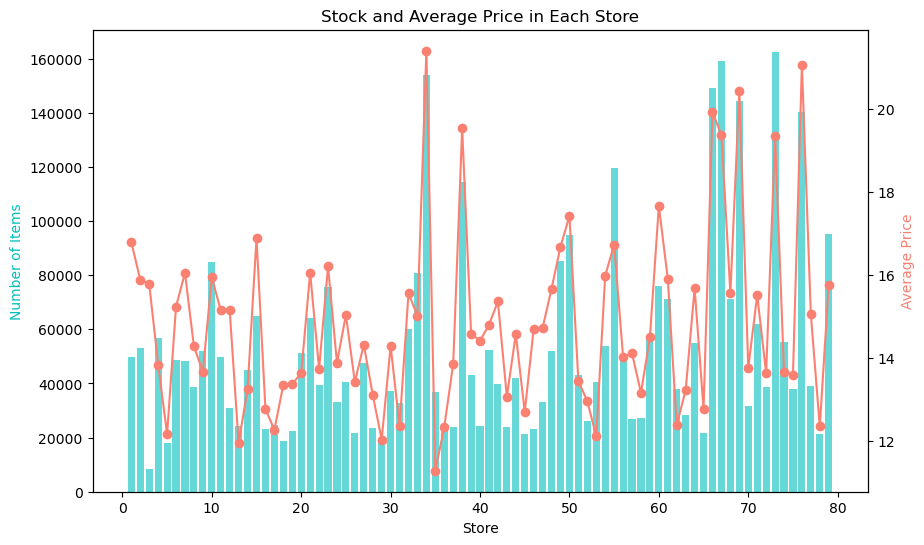

The stock at the end of the year:


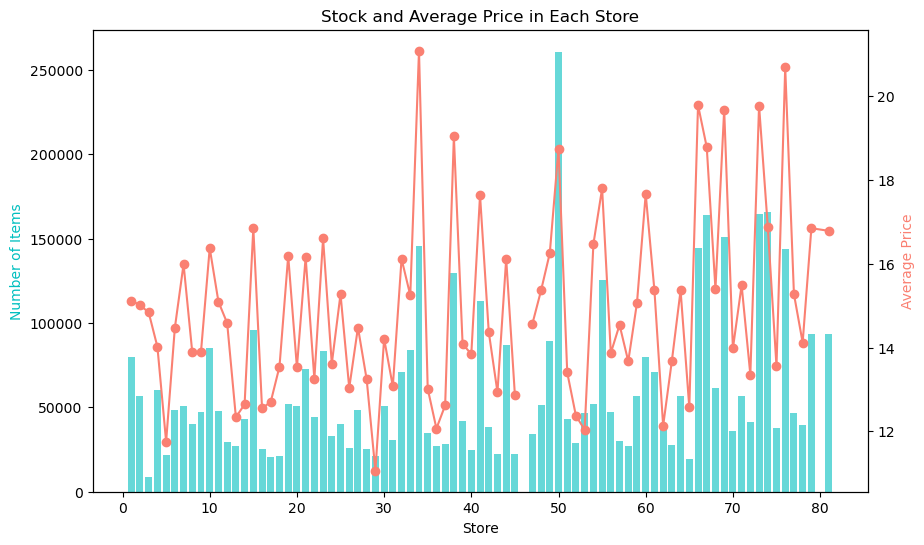

In [117]:
print ("The stock at the beginning of the year:")
f1 = plot_stock(df_begin)
plt.show()
print ("The stock at the end of the year:")
f2 = plot_stock(df_end)
plt.show()


2. sales data

In [118]:
df_sale.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName'],
      dtype='object')

In [119]:
df_sale['SalesDate'] = pd.to_datetime(df_sale['SalesDate'])
sales_dates = sorted(df_sale['SalesDate'].unique())
print("The sales data is from ", sales_dates[0].strftime('%b %d'), " to ", sales_dates[-1].strftime('%b %d'))

The sales data is from  Jan 01  to  Feb 29


We visualize the daily overall sale of all stores during this period

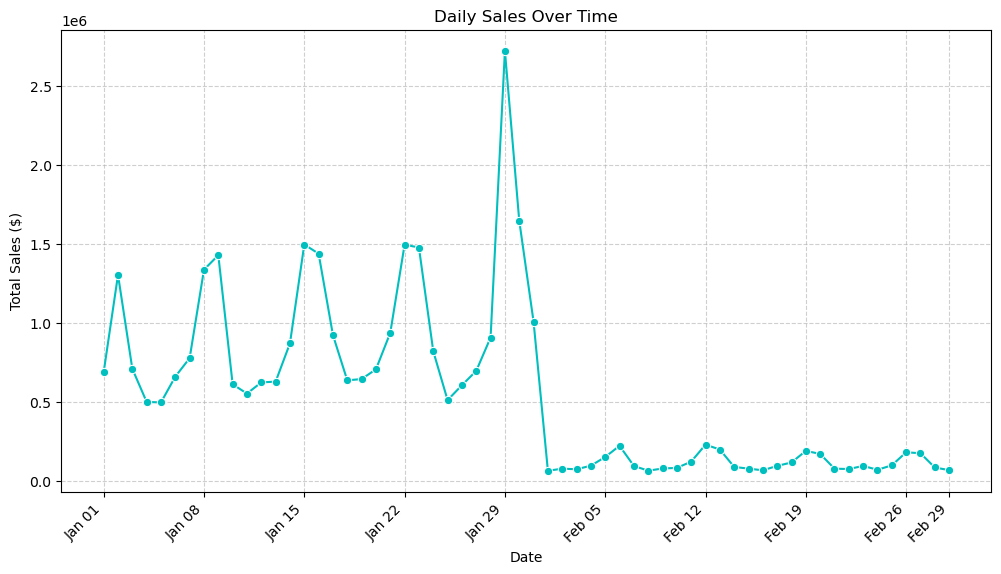

In [120]:
# Visualize the total daily sales
ticks = []
sales_by_store = df_sale.groupby('SalesDate')[['SalesDollars']].agg({'SalesDollars':'sum'})
sales_by_store = sales_by_store.sort_index()
ticks = [date.strftime('%b %d') for date in sales_by_store.index]

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=sales_by_store, x=sales_by_store.index, y='SalesDollars', 
             marker='o', ax=ax, color='c')

ax.set(xlabel='Date', ylabel='Total Sales ($)', title='Daily Sales Over Time')
xticks = list(range(0, len(ticks), 7))
if len(ticks)-1 not in xticks:
    xticks.append(-1)
ax.set_xticks(sales_by_store.index[xticks])
ax.set_xticklabels([ticks[i] for i in xticks], rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

We notice that the pattern has to do with weekdays, so we visualize the average sale during each weekdays.

/var/folders/f0/zl7mb5012g7bd9hg0h3mx7lc0000gn/T/ipykernel_24042/2567890651.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


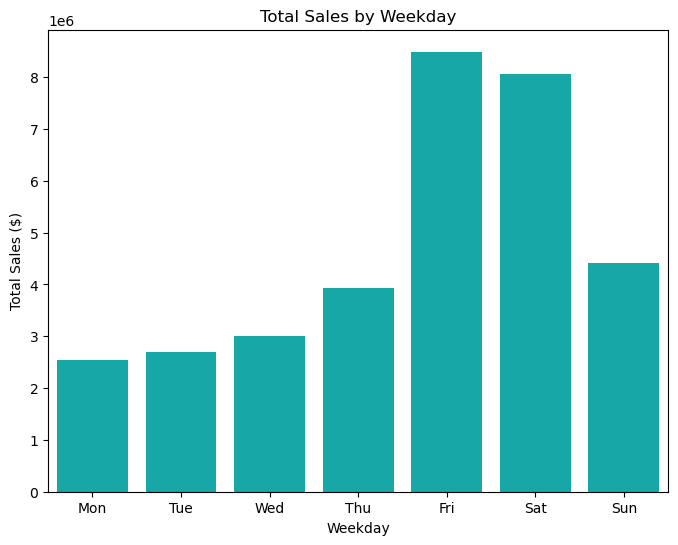

In [121]:
# Visualize the total sales by weekdays
df_sale['Weekday'] = df_sale['SalesDate'].dt.weekday
sales_by_weekday = df_sale.groupby('Weekday')[['SalesDollars']].agg({'SalesDollars':'sum'})
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=sales_by_weekday, x=sales_by_weekday.index, y='SalesDollars', ax=ax, color='c')
ax.set(xlabel='Weekday', ylabel='Total Sales ($)', title='Total Sales by Weekday')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [122]:
# get the patter by city
city_store = df_begin[['Store', 'City']].drop_duplicates().set_index('Store')
df_sale['City'] = df_sale['Store'].map(city_store['City'])
sales_by_city = df_sale.groupby('City')[['SalesDollars']].agg({'SalesDollars': 'sum'})
sales_by_city = sales_by_city.sort_values('SalesDollars', ascending=False)
print("Our data contains sales data from ", len(city_store), " stores in ", len(sales_by_city), " cities.")

Our data contains sales data from  79  stores in  67  cities.


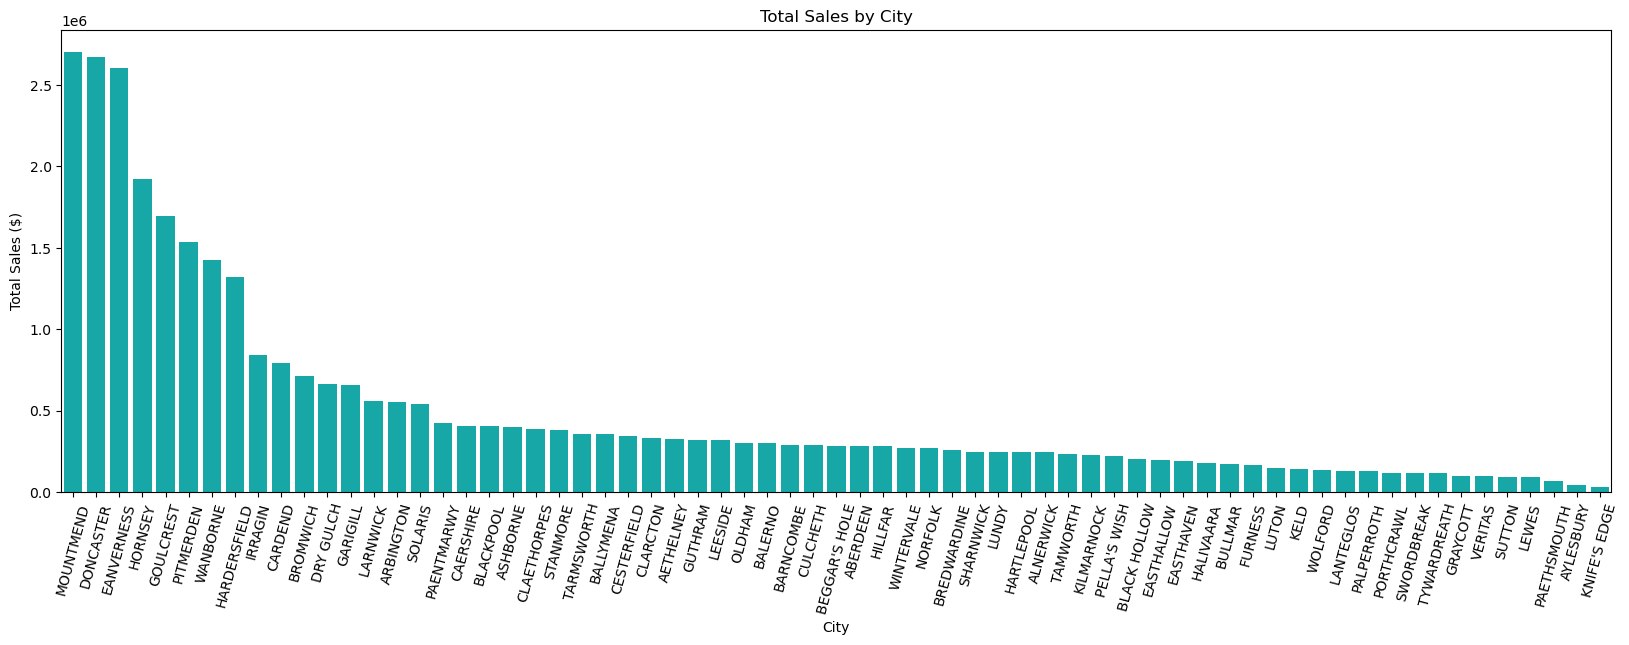

In [123]:
# Visualize the total sales by city
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=sales_by_city, x=sales_by_city.index, y='SalesDollars', ax=ax, color='c')
ax.set(xlabel='City', ylabel='Total Sales ($)', title='Total Sales by City')
plt.xticks(rotation=75)
plt.show()

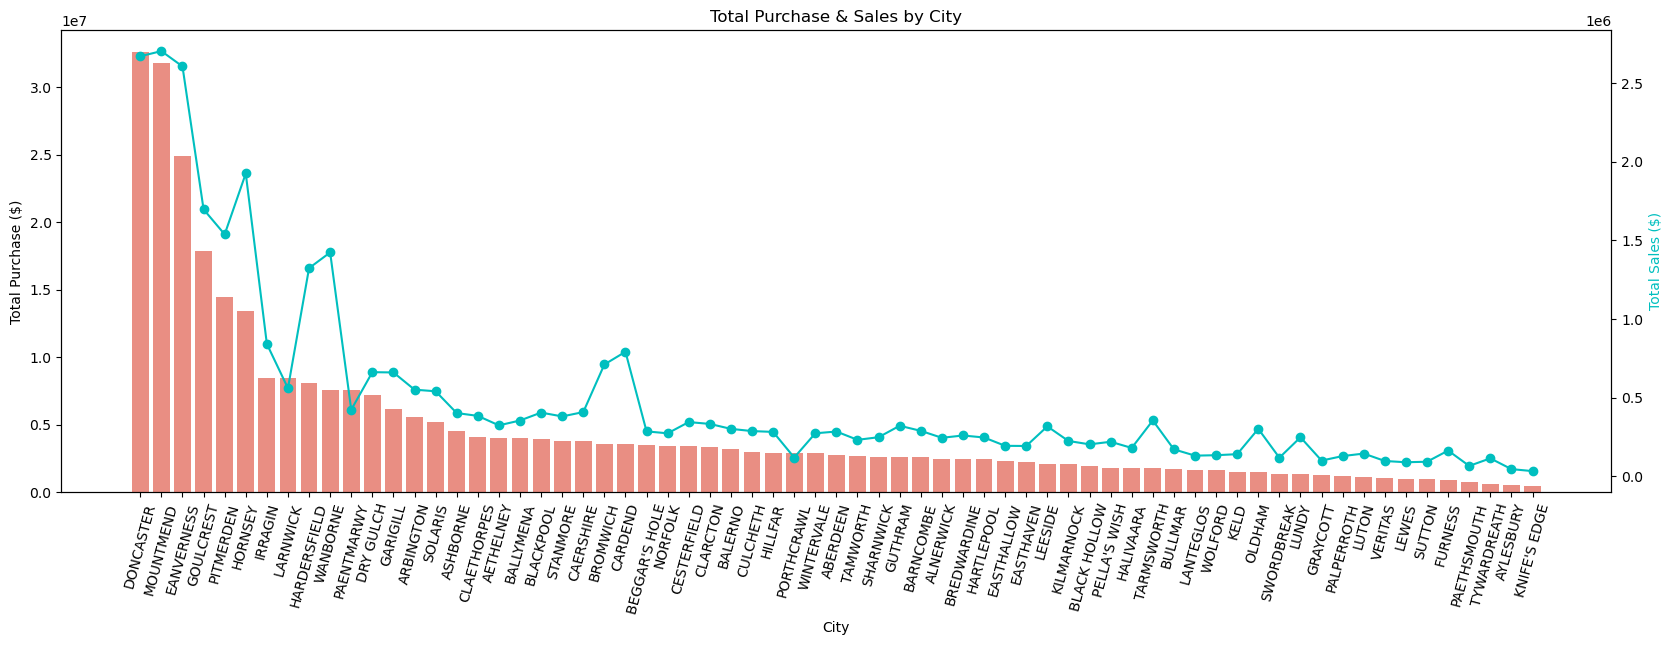

In [140]:
# show the purchase by city as well
df_pur2016['City'] = df_pur2016['Store'].map(city_store['City'])
purchase_by_city = df_pur2016.groupby('City')[['Dollars']].agg({'Dollars': 'sum'})
purchase_by_city = purchase_by_city.sort_values('Dollars', ascending=False)
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=purchase_by_city, x=purchase_by_city.index, y='Dollars', ax=ax, color='salmon')
ax.set(xlabel='City', ylabel='Total Purchase ($)', title='Total Purchase & Sales by City')
plt.xticks(rotation=75)

# We merge the sales and purchase by city together
sales_by_city = sales_by_city.reindex(purchase_by_city.index)
ax2 = ax.twinx()
ax2.plot(sales_by_city.index, sales_by_city['SalesDollars'], color='c', marker='o')
ax2.set_ylabel('Total Sales ($)', color='c')


plt.show()


We Categorize the cities into 3 group:</br>
Low, medium, and high sales cities.

/var/folders/f0/zl7mb5012g7bd9hg0h3mx7lc0000gn/T/ipykernel_24042/817539565.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_sum = sales_by_city.groupby('Category').agg({'SalesDollars': 'sum', 'Category': 'count'})


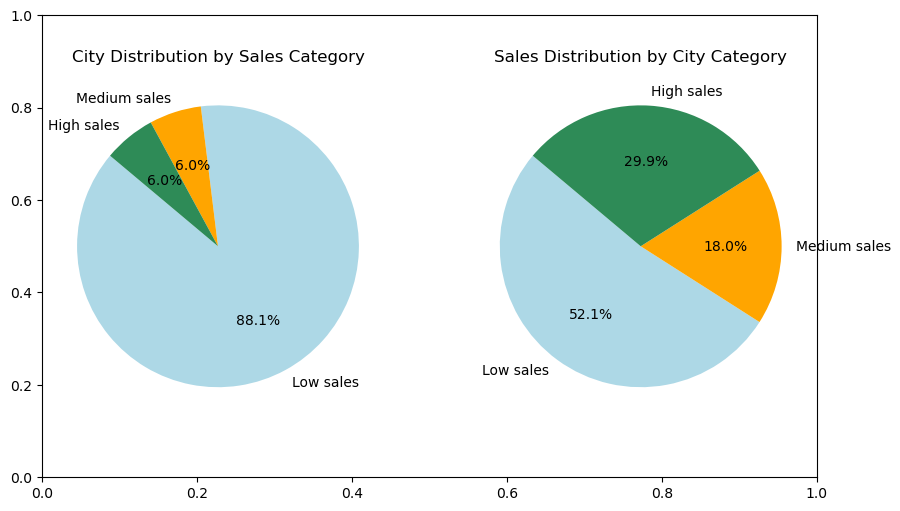

,SalesDollars,Category
Category,,
Low sales,17257373.61,59
Medium sales,5980648.30,4
High sales,9901353.38,4


In [124]:
# Give category for the city by total sales into 3 groups, by the total sales
sales_by_city['Category'] = pd.cut(sales_by_city['SalesDollars'], bins=3, labels=['Low sales', 'Medium sales', 'High sales'])
city_sum = sales_by_city.groupby('Category').agg({'SalesDollars': 'sum', 'Category': 'count'})
# Visualize the city count and sales distribution for each category
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pie(city_sum['Category'], labels=city_sum.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'orange', 'seagreen'])
plt.title("City Distribution by Sales Category")
plt.subplot(1, 2, 2)
plt.pie(city_sum['SalesDollars'], labels=city_sum.index, 
        autopct='%1.1f%%', startangle=140, colors=['lightblue', 'orange', 'seagreen'])
plt.title("Sales Distribution by City Category")
plt.show()
city_sum

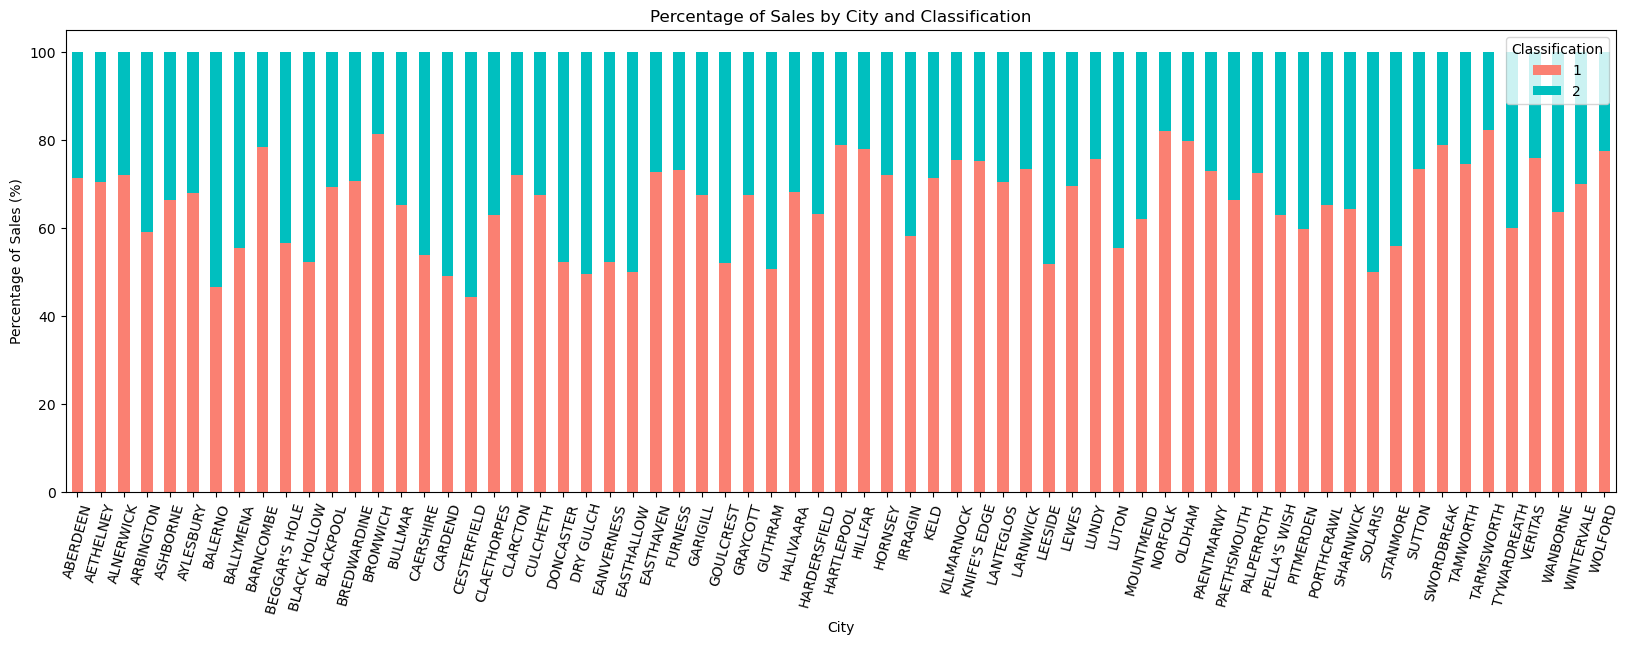

In [ ]:
# get the percentage by product category in each city
product_city = df_sale.groupby(['City', 'Classification'])[['SalesDollars']].agg({'SalesDollars': 'sum'}).reset_index()
product_city['percentage'] = product_city.groupby('City')['SalesDollars'].apply(lambda x: x / x.sum() * 100).values

product_city_pivot = product_city.pivot(index='City', columns='Classification', values='percentage').fillna(0)
product_city_pivot.plot(kind='bar', stacked=True, figsize=(20, 6), color=[custom_palette[1], custom_palette[2]])
plt.xlabel('City')
plt.ylabel('Percentage of Sales (%)')
plt.title('Percentage of Sales by City and Classification')
plt.xticks(rotation=75)
plt.legend(title='Classification')
plt.show()

We test the correlations of price, volume, tax and quantity

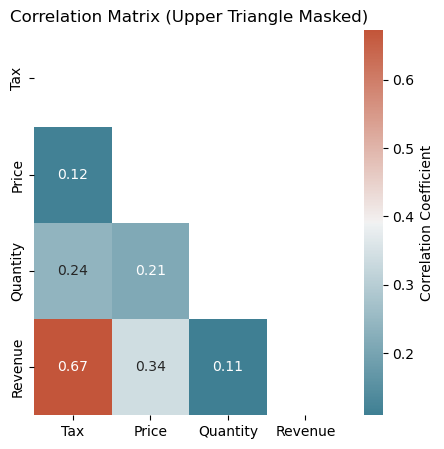

In [ ]:
# Excise tax Correlation to Sale price and volume and total sale
correlation = df_sale[['ExciseTax','SalesPrice','Volume','SalesDollars']].corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(5, 5))
sns.heatmap(correlation, annot=True, xticklabels=['Tax', 'Price', 'Quantity', 'Revenue'], 
            yticklabels=['Tax', 'Price', 'Quantity', 'Revenue'], mask=np.triu(correlation), cmap=cmap, 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix (Upper Triangle Masked)")
plt.show()

From the plot, tax should be an important factor to consider to maximize revenue

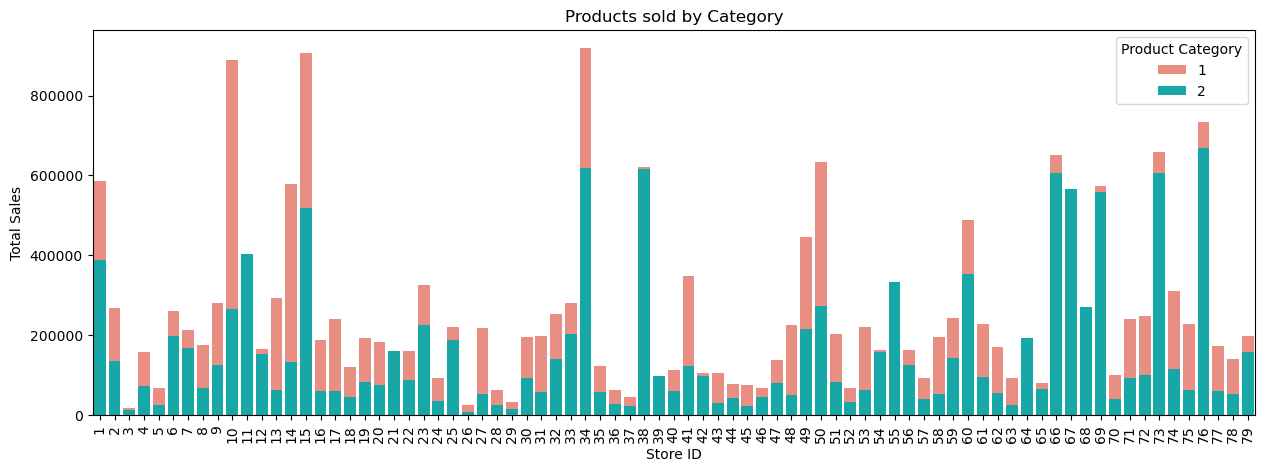

In [ ]:
# Aggregated sales showing the products sold by category
aggregated_sales = df_sale.groupby(['Store','Classification'],as_index=False)[['SalesDollars']].agg(TotalSales=('SalesDollars','sum'))
aggregated_sales.set_index('Store',inplace=True)

fig,ax=plt.subplots(1,1,figsize=(15,5))
sns.barplot(data=aggregated_sales, x=aggregated_sales.index,
            y='TotalSales', ax=ax, hue='Classification', dodge=False, palette=custom_palette)
ax.set(xlabel='Store ID', ylabel='Total Sales', title='Products sold by Category')
ax.legend(title='Product Category')
plt.xticks(rotation=90)
plt.show()

### B. purchases
- There are three tables record the purchases information
1. PurchasesFINAL12312016.csv: the detail(time/price/items/location..) of each purchase in 2016
2. InvoicePurchases12312016.csv: the transaction with each company
3. 2017PurchasePricesDec.csv: the purchase price in 2017(future)

In [ ]:
df_pur2016.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber',
       'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate',
       'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification'],
      dtype='object')

We first visualize the total purchase during 2016 for each store</br>
We show the total purchase cost. Also, the quantity purchased by each store is visualized.

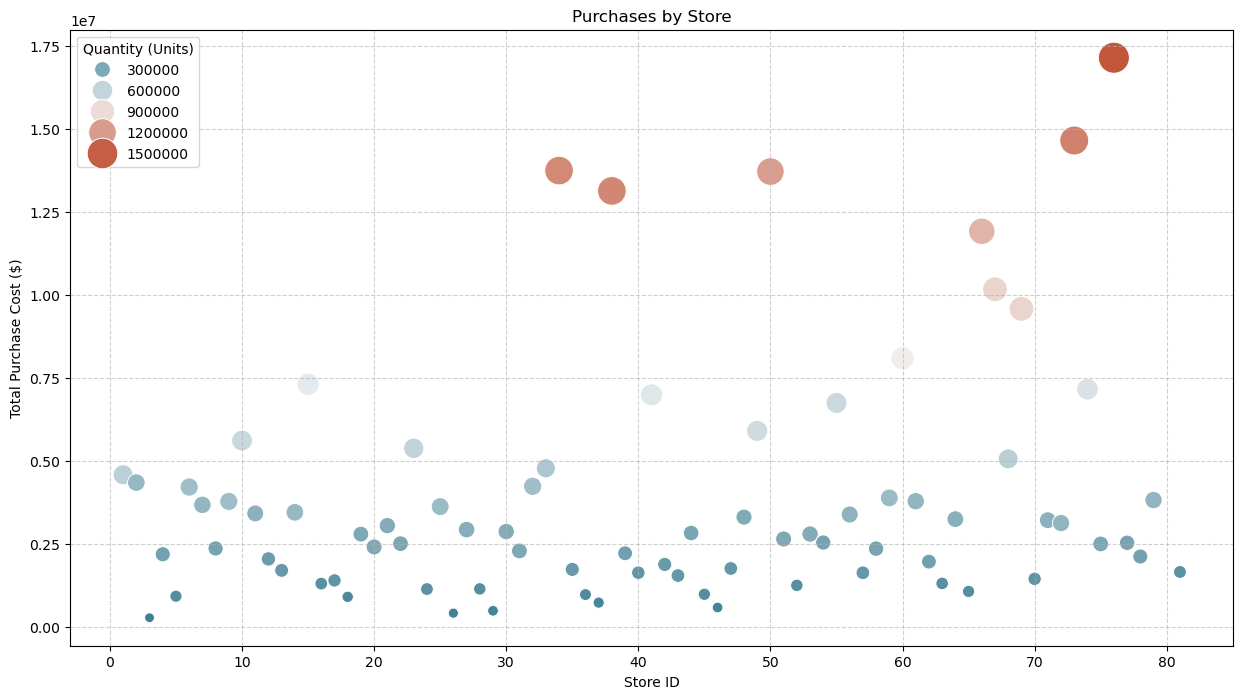

In [ ]:
# Plotting the purchases by store
purchases_df = df_pur2016[df_pur2016['InvoiceDate']<=datetime.datetime(2016,12,31)]
grouped_purchases = purchases_df.groupby('Store').agg({'Dollars':'sum','Quantity':'sum'})
grouped_purchases = grouped_purchases.sort_values('Store')

palette_for_scatter = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(15, 8))
scatter = sns.scatterplot(
    data=grouped_purchases, x='Store', y='Dollars', 
    size='Quantity', hue='Quantity', palette=palette_for_scatter, 
    sizes=(50, 500), ax=ax, legend=True
)

ax.set(xlabel='Store ID', ylabel='Total Purchase Cost ($)', title='Purchases by Store')
ax.grid(True, linestyle='--', alpha=0.6)
handles, labels = scatter.get_legend_handles_labels()
ax.legend(handles=handles, title="Quantity (Units)")
plt.show()

Some of the stores have overall higher purchase as what we have observed from stock before<\br>
It indicates that the stores operate on different scales. The mojority of store runs in small scale.

Next we look into purchase by month

In [ ]:

# Plotting the purchases made each month
df_invoice['Month'] = df_invoice['InvoiceDate'].dt.month
purchases_by_month = df_invoice[df_invoice['InvoiceDate'] <= 
                                datetime.datetime(2016,12,31)].groupby('Month')[['Dollars']].agg({'Dollars':'mean'})
invoices_merged_purchases = df_invoice.merge(purchases_df,on='PONumber',
                                             suffixes=('_invoice','_purchase'),how='inner')
per_month_categories = invoices_merged_purchases.groupby(['Month','Classification'],
                                                         as_index=False).agg({'Quantity_purchase':'sum'})
melted_df = per_month_categories.pivot(index='Month',columns='Classification',
                                       values='Quantity_purchase')

We look into the diference between two product category, as well as the total purchase cost

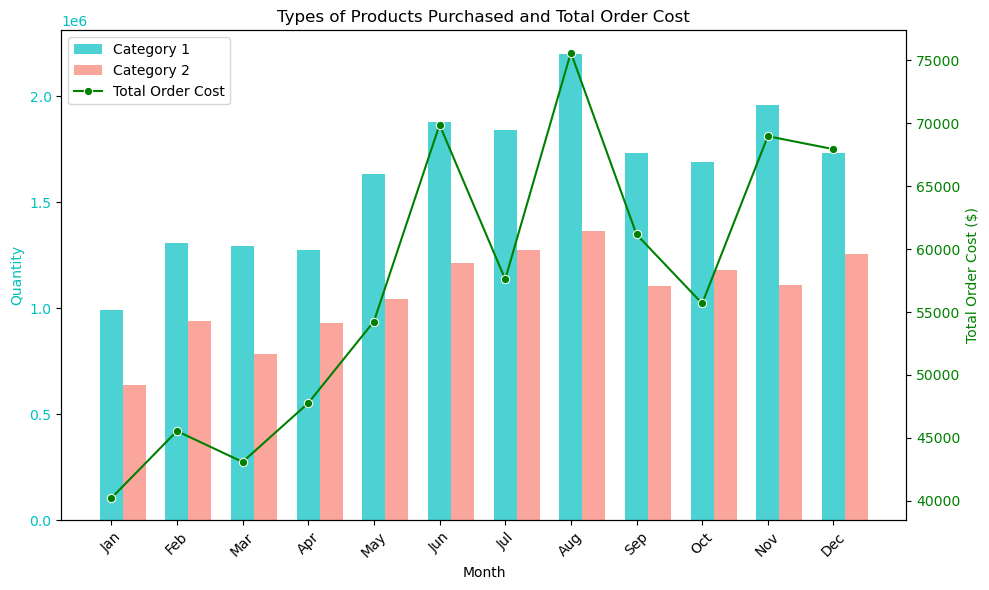

In [ ]:
x = range(len(melted_df.index))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bar_width = 0.35

fig1, ax1 = plt.subplots(figsize=(10, 6))
# plot the bars for each category
category1_bars = ax1.bar(x, melted_df.iloc[:, 0], bar_width, label='Category 1', color='c', alpha=0.7)
category2_bars = ax1.bar([i + bar_width for i in x], melted_df.iloc[:, 1], bar_width, 
                         label='Category 2', color='salmon', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Quantity', color='c')
ax1.tick_params(axis='y', labelcolor='c')

# Plot the line chart for total order cost
ax2 = ax1.twinx()
sns.lineplot(data=purchases_by_month, y='Dollars', x=purchases_by_month.index-1,
             marker='o', ax=ax2, color='g', label='Total Order Cost')

ax1.set_xticks(range(len(month_labels)))
ax1.set_xticklabels(month_labels[:len(x)], rotation=45)

ax2.set_ylabel('Total Order Cost ($)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.get_legend().remove()


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title('Types of Products Purchased and Total Order Cost')
plt.tight_layout()
plt.show()

We can see that the overall purchase increase over the year. Also, the peak appears during summer.</br>
In general, products from Category 1 have higher purchase volumes 


We also look at the relathionship between the purchase quantity and the delay of payment.

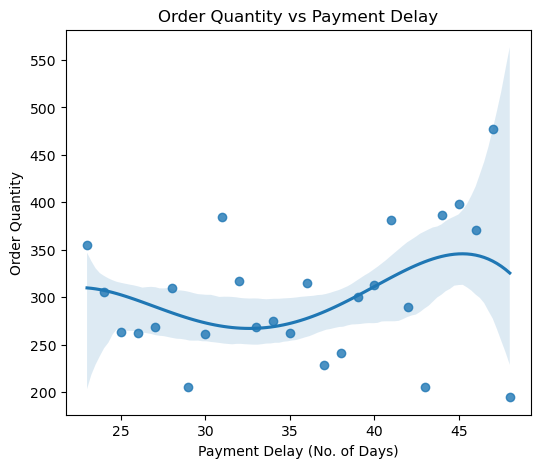

In [ ]:
#Plot the order Quantity and the delay in payment
df_invoice['DateDifference'] = (df_invoice['PayDate']- df_invoice['InvoiceDate']).dt.days
payments_delay = df_invoice.groupby('DateDifference',as_index=False)[['Quantity','Dollars','Freight']].agg({'Quantity':'mean','Dollars':'mean','Freight':'mean'})

fig,ax=plt.subplots(1,1,figsize=(6,5))
sns.regplot(data=payments_delay,y='Freight',x='DateDifference',ax=ax,order=4,ci=75)
ax.set(xlabel='Payment Delay (No. of Days)',ylabel='Order Quantity',title='Order Quantity vs Payment Delay')
plt.show()

## 3. Combined Analysis

We analyze by products on their stock and profit

In [ ]:
#Get the starting inventory data for each brand
starting_inventory_by_brand = df_begin.groupby('Brand')[['onHand','Price']].agg({'onHand':'sum','Price':'mean'}).reset_index()
starting_inventory_by_brand.columns = ['Brand','Quantity','Price']

#Get the purchase data for each brand
purchases_by_brand = df_pur2016[df_pur2016['InvoiceDate']<datetime.datetime(2016,3,1)].groupby('Brand')[['Quantity','PurchasePrice']].agg({'Quantity':'sum','PurchasePrice':'mean'}).reset_index()
purchases_by_brand.columns = ['Brand','Quantity','Price']

In [ ]:
# Get the investment into each brand
investment = pd.concat([purchases_by_brand,starting_inventory_by_brand],ignore_index=True)
investment = investment.groupby('Brand').agg({'Quantity':'sum','Price':'mean'}).reset_index()
investment['Investment'] = investment['Quantity']*investment['Price']

In [ ]:
# Get the sales for each brand
sales_by_brand = df_sale.groupby('Brand')[['SalesQuantity','SalesPrice']].agg({'SalesQuantity':'sum','SalesPrice':'mean'}).reset_index()
sales_by_brand.columns = ['Brand','Quantity','Price']
sales_by_brand['TotalSales'] = sales_by_brand['Quantity'] * sales_by_brand['Price']

In [ ]:
# Get the profit for each brand
profit = investment.merge(sales_by_brand,on='Brand',suffixes=('_invest','_sale'))
profit['StockLeft'] = profit['Quantity_invest']-profit['Quantity_sale']
profit['Profit'] = profit['TotalSales'] - profit['Quantity_sale'] * profit['Price_invest']

In [ ]:
# Extract the brand description for the plots
brand_description = pd.concat([df_sale[['Brand','Description']],df_begin[['Brand','Description']],df_end[['Brand','Description']],df_pur2016[['Brand','Description']]])
brand_description = brand_description.drop_duplicates()
brand_description = brand_description.set_index('Brand')

In [ ]:
# Pick the top 5 brands for profit and stock

top_5_brands_by_profit = profit.sort_values(by='Profit',ascending=False)[['Brand','Profit']].head(5)
top_5_brands_by_profit['Brand'] = top_5_brands_by_profit['Brand'].apply(lambda x : brand_description.loc[int(x)]['Description'])
top_5_brands_by_profit = top_5_brands_by_profit.set_index('Brand')

top_5_brands_by_stock = profit.sort_values(by='StockLeft',ascending=False)[['Brand','StockLeft']].head(5)
top_5_brands_by_stock['Brand'] = top_5_brands_by_stock['Brand'].apply(lambda x : brand_description.loc[int(x)]['Description'])
top_5_brands_by_stock = top_5_brands_by_stock.set_index('Brand')

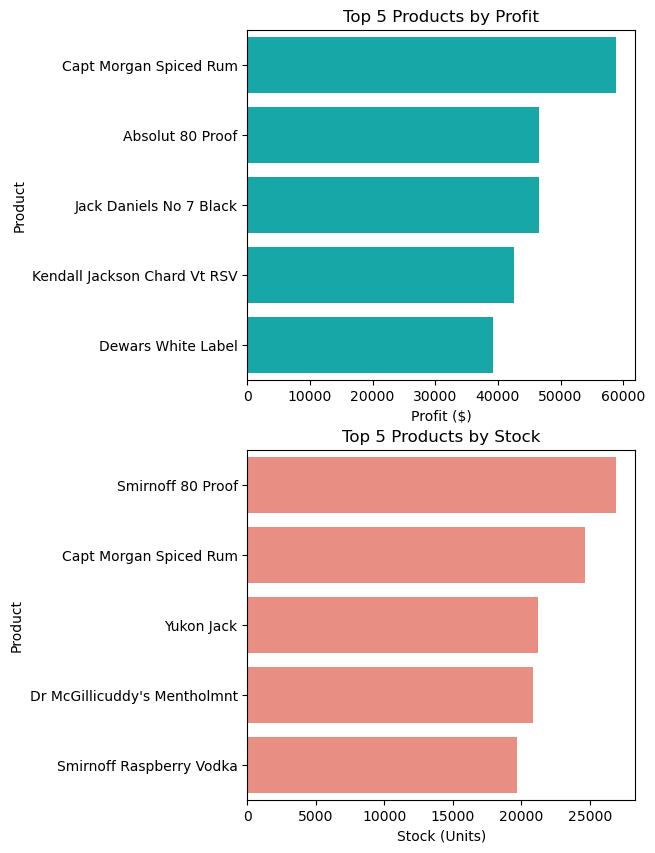

In [ ]:
#Plot the profit and stock for these top 5 brands

fig,ax = plt.subplots(2,1,figsize=(5,10))
sns.barplot(data = top_5_brands_by_profit , y=top_5_brands_by_profit.index,
            x='Profit',ax=ax[0], color='c')
sns.barplot(data = top_5_brands_by_stock , y=top_5_brands_by_stock.index,
            x='StockLeft',ax=ax[1], color='salmon')
ax[0].set(title='Top 5 Products by Profit',xlabel='Profit ($)',ylabel='Product')
ax[1].set(title='Top 5 Products by Stock',xlabel='Stock (Units)',ylabel='Product')
plt.show()

We investigate the situation of stock for different products. </br>
We categorize the stock status into four types: </br>
1. Out Of Stock/abnormal: the stock level is zero, or a negative value occurs
2. Re-order: the stock is low (end stock percentile ≤ 30% of initial investment quantity)
3. Slow Moving: 30%-75% stock remaining
4. Holding Stock: 75% stock remaining

In [ ]:
#Get the ending inventory for each brand
ending_inventory_by_brand = df_end.groupby('Brand')[['onHand','Price']].agg({'onHand':'sum','Price':'mean'}).reset_index()
ending_inventory_by_brand.columns = ['Brand','Quantity','Price']
ending_inventory_by_brand['TotalValue'] = ending_inventory_by_brand['Quantity'] * ending_inventory_by_brand['Price']

In [ ]:
#For the 2016 purchases file, get the investment into each brand

purchases_by_brand_16 = df_pur2016[df_pur2016['InvoiceDate']<=datetime.datetime(2016,12,31)].groupby('Brand')[['Quantity','PurchasePrice']].agg({'Quantity':'sum','PurchasePrice':'mean'}).reset_index()
purchases_by_brand_16.columns = ['Brand','Quantity','Price']

investment_16 = pd.concat([purchases_by_brand_16,starting_inventory_by_brand],ignore_index=True)
investment_16 = investment_16.groupby('Brand').agg({'Quantity':'sum','Price':'mean'}).reset_index()
investment_16['Investment'] = investment_16['Quantity']*investment_16['Price']

In [ ]:
#Ending inventory for the 2016 file

ending_inventory_by_brand.columns=['Brand',	'Quantity','Price','Total_sale']
stock = investment_16.merge(ending_inventory_by_brand,on='Brand',suffixes=('_invest','_sale'))
stock['StockLeft'] = stock['Quantity_invest']-stock['Quantity_sale']

In [ ]:
# Based on the stock left percentile, assignt the category
stock_categories={
    0:'Out of Stock',
    1: 'Re order',
    2: 'Slow Moving Stock',
    3: 'Excess/Obsolete',
}
def get_stock_category(df):
    begin,end = df['Quantity_invest'], df['StockLeft']

    if ~np.isnan(begin)  and ~np.isnan(end):
        percentile = stats.percentileofscore(np.arange(0,begin),end)

        if end<0:
            return 0
        if end==0 and begin>0:
            return 0
        if percentile<=30:
            return 1
        if percentile>30 and percentile<=75:
            return 2
        if percentile>75 and percentile<=100:
            return 3
            
    if begin==0 and np.isnan(end):
        return 0
    
    if np.isnan(begin) and ~np.isnan(end):
        return 4

    if ~np.isnan(begin) and np.isnan(end):
        return 0

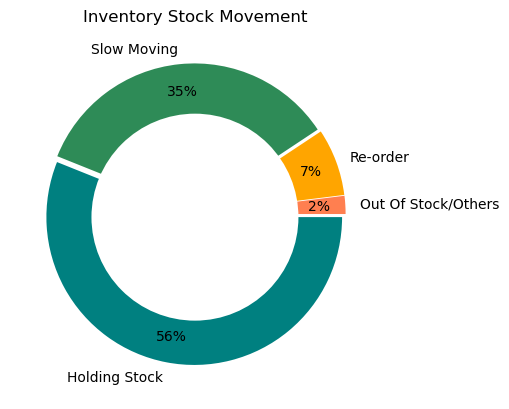

In [ ]:
#Assign stock category to the dataframe

stock['StockCategory'] = stock[['Quantity_invest','StockLeft']].apply(lambda x :get_stock_category(x), axis=1)
inventory_stock_analysis = stock.groupby('StockCategory')['StockCategory'].value_counts().reset_index(name='counts')

# Donut chart of inventory stock categories
colors = ['coral', 'orange', 'seagreen', 'teal']
plt.pie(inventory_stock_analysis['counts'],labels=['Out Of Stock/Others','Re-order','Slow Moving','Holding Stock'],autopct='%1.0f%%', pctdistance=0.82,
        explode=[ 0.02, 0.02, 0.02, 0.02], colors=colors)
centre_circle = plt.Circle((0.001, -0.02), 0.7, fc='white')
fig = plt.gcf()
 
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
plt.title('Inventory Stock Movement')
plt.show()

We perform Economic Order Quantity (EOQ) analysis to determine the optimal order quantity for each product. 

In [ ]:
# To calculate Order Cost, we use purchases and find the average order cost of each product. (H)

avg_order_cost = df_pur2016[df_pur2016['InvoiceDate']
    <=datetime.datetime(2016,12,31)].groupby('Brand')[[
        'Quantity','PurchasePrice','Dollars']].agg(
        TotalOrderQuantity=('Quantity','sum'),
        AvgProductCost=('PurchasePrice','mean'),
        AvgOrderValue=('Dollars','mean'),
        TotalOrderCost=('Dollars','sum')).reset_index()
avg_order_cost = avg_order_cost.set_index('Brand')

avg_sale_price = df_sale.groupby('Brand').agg(TotalSaleQuantity=('SalesQuantity','sum'),TotalSales=('SalesDollars','sum'),AvgSalePrice=('SalesPrice','mean')).reset_index()

## 4. Prediction